In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


In [47]:
data = pd.read_csv('../db/AmesHousing.csv', sep='\t')
# drop all columns with too many Nan 
for column in data:
    if data[column].isna().sum()>2000:
        print(column)
        data.drop(column, axis=1, inplace=True)

# drop rows 
data.drop([1341, 2236], axis=0, inplace=True)

Alley
Pool QC
Fence
Misc Feature


In [48]:
string = ''
for col in data:
   string += f"{col}: {data[col].isnull().sum()} "


print(string) 
# 1341, 2236

print(data['Garage Qual'])



Order: 0 PID: 0 MS SubClass: 0 MS Zoning: 0 Lot Frontage: 490 Lot Area: 0 Street: 0 Lot Shape: 0 Land Contour: 0 Utilities: 0 Lot Config: 0 Land Slope: 0 Neighborhood: 0 Condition 1: 0 Condition 2: 0 Bldg Type: 0 House Style: 0 Overall Qual: 0 Overall Cond: 0 Year Built: 0 Year Remod/Add: 0 Roof Style: 0 Roof Matl: 0 Exterior 1st: 0 Exterior 2nd: 0 Mas Vnr Type: 1773 Mas Vnr Area: 23 Exter Qual: 0 Exter Cond: 0 Foundation: 0 Bsmt Qual: 79 Bsmt Cond: 79 Bsmt Exposure: 82 BsmtFin Type 1: 79 BsmtFin SF 1: 0 BsmtFin Type 2: 80 BsmtFin SF 2: 0 Bsmt Unf SF: 0 Total Bsmt SF: 0 Heating: 0 Heating QC: 0 Central Air: 0 Electrical: 1 1st Flr SF: 0 2nd Flr SF: 0 Low Qual Fin SF: 0 Gr Liv Area: 0 Bsmt Full Bath: 1 Bsmt Half Bath: 1 Full Bath: 0 Half Bath: 0 Bedroom AbvGr: 0 Kitchen AbvGr: 0 Kitchen Qual: 0 TotRms AbvGrd: 0 Functional: 0 Fireplaces: 0 Fireplace Qu: 1420 Garage Type: 157 Garage Yr Blt: 158 Garage Finish: 158 Garage Cars: 0 Garage Area: 0 Garage Qual: 158 Garage Cond: 158 Paved Drive:

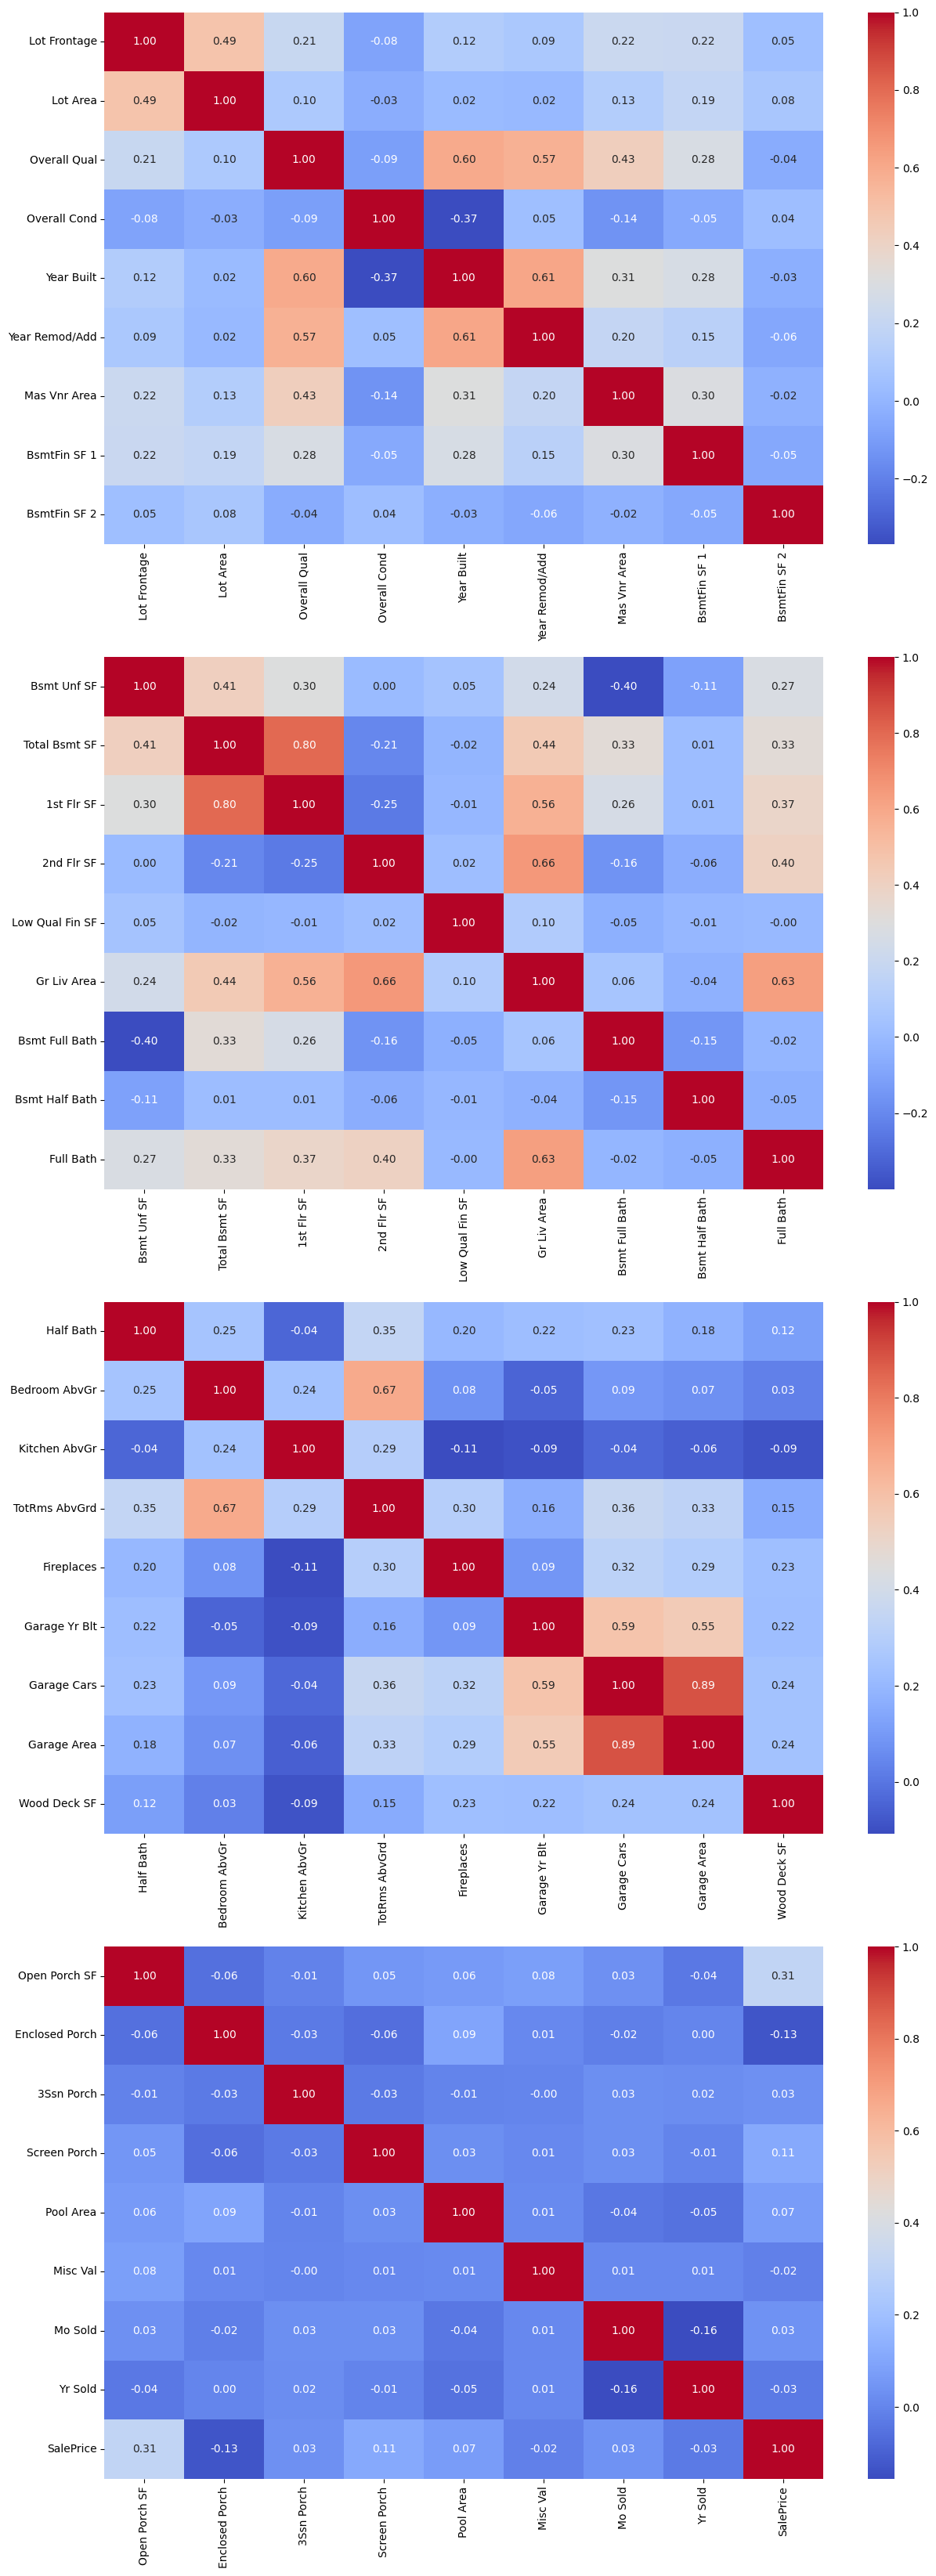

In [49]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
cat_features = ['Order', 'PID', 'MS SubClass']
numerical_data = data.drop(cat_features, axis=1).select_dtypes(include=numerics)

num_df1 = numerical_data.iloc[:, :9]
num_df2 = numerical_data.iloc[:, 9:18]
num_df3 = numerical_data.iloc[:, 18:27]
num_df4 = numerical_data.iloc[:, 27:]


corr1 = num_df1.corr()
corr2 = num_df2.corr()
corr3 = num_df3.corr()
corr4 = num_df4.corr()

fig, axis = plt.subplots(4, 1, figsize=(13, 33))
sns.heatmap(corr1,ax=axis[0], annot=True , fmt='.2f', cmap='coolwarm')
sns.heatmap(corr2, ax=axis[1], annot=True, fmt='.2f', cmap='coolwarm')
sns.heatmap(corr3, ax=axis[2], annot=True, fmt='.2f', cmap='coolwarm')
sns.heatmap(corr4, ax=axis[3], annot=True, fmt='.2f', cmap='coolwarm')
plt.tight_layout()
plt.show()



Information of the target variable: 
{'mean': np.float64(180841.0338114754), 'median': np.float64(160000.0), 'max': np.int64(755000), 'min': np.int64(12789)}


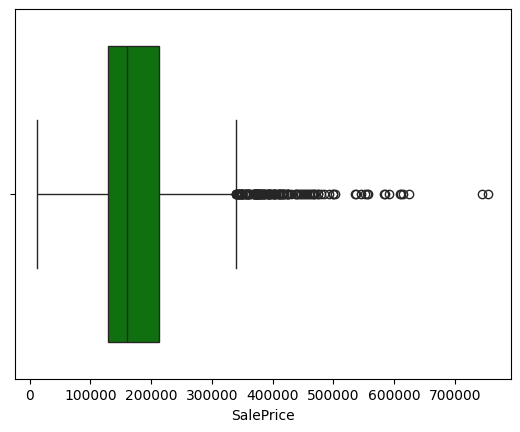

[160000 160000]
1465 1463
Q1: 129500.0
Q2: 160000.0
Q3: 213500.0
min:12789
max: 755000
(2928, 78)


In [50]:
# discretization of the target variable 
Y = data.iloc[:, 77]

infos = {}
infos['mean'] = np.mean(np.array(Y))
infos['median'] = np.median(np.array(Y))
infos['max'] = np.max(np.array(Y))
infos['min'] = np.min(np.array(Y))
print(f"Information of the target variable: \n{infos}")

sns.boxplot(x=Y, vert=False, color='green')
plt.show()

# compute the quartiles 
# step 1: copy/sort the data
Y_copy = Y.copy(deep=True).sort_values(ascending=True)
length = len(Y_copy)
# a ranges vector that defines the classes: e.g. for the class 1 we must look up to be between the 
# ranges[0] and ranges[1] => for each class 'i' the range is defined by (ranges[i-1], ranges[i])
ranges = [infos['min'], -1, -1, -1, infos['max']]

# length is even then:
# Q2 = mean(length/2, length/2-1)
Q2 = np.mean(np.array(Y_copy.iloc[(length//2)-1:length//2+1]))
print(np.array(Y_copy.iloc[(length//2)-1:length//2+1]))
# split the Series and compute the Q1, Q3
cond = Y_copy <= Q2
half1, half2 = Y_copy[cond], Y_copy[~cond]
print(len(half1), len(half2))
Q1 = np.median(np.array(half1))
Q3 = np.median(np.array(half2))
print(f"Q1: {Q1}\nQ2: {Q2}\nQ3: {Q3}\nmin:{infos['min']}\nmax: {infos['max']}") 
ranges[1] = Q1
ranges[2] = Q2 
ranges[3] = Q3

# change the target varaible to a categorical format
classes = ["cheap", "affordable", "expensive", "billionaire type of shit"]
cat_y: list[str] = []
for y in Y:
    if y <= ranges[1]:
        cat_y.append(classes[0])
    elif y <= ranges[2]:
        cat_y.append(classes[1])
    elif y <= ranges[3]:
        cat_y.append(classes[2])
    else:
        cat_y.append(classes[3])

print(data.shape)
X = data.iloc[:, :77]
Y = pd.Series(cat_y)


In [51]:
# Label encoding of the ordinal features
import math

# finding all the categories per each feature to be able to encode them 
# find them dynamically so in case of a dataset change the code adapts itself
ords = {}
ords_cols = ['Exter Qual', 'Exter Cond', 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin Type 2', 'Heating QC', 'Kitchen Qual', 'Functional', 'Fireplace Qu', 'Garage Finish', 'Garage Qual', 'Garage Cond', 'Sale Type']
for col in ords_cols:
    categories_withNaN = set(X[col])
    categories_withoutNaN = set(x for x in X[col] if not (isinstance(x, float) and math.isnan(x)))
    if len(categories_withoutNaN) != len(categories_withNaN):
        ords[col] = [*categories_withoutNaN, np.nan]
    else:
        ords[col] = [*categories_withoutNaN]
print(ords)

from sklearn.preprocessing import OrdinalEncoder

# for the record to see if we have NaN values so we could handle it
for col in list(ords.keys()):
    print(f"{col}: {X[col].isna().sum()}")


# Printing the set of the categories and their encoded relatives
for col, ordering in ords.items():
    enc = OrdinalEncoder(categories=[ordering], encoded_missing_value=-1)
    X[col] = enc.fit_transform(X[[col]])
    print(f"{set(X[col])}\n{ordering}\n\n")


enc = OrdinalEncoder(categories=[classes])

Y = enc.fit_transform(pd.DataFrame(Y))
Y = pd.DataFrame(Y)
Y


{'Exter Qual': ['Gd', 'Ex', 'TA', 'Fa'], 'Exter Cond': ['Ex', 'Gd', 'Po', 'TA', 'Fa'], 'Bsmt Qual': ['Ex', 'Gd', 'Po', 'TA', 'Fa', nan], 'Bsmt Cond': ['Ex', 'Gd', 'Po', 'TA', 'Fa', nan], 'Bsmt Exposure': ['Gd', 'No', 'Mn', 'Av', nan], 'BsmtFin Type 1': ['GLQ', 'BLQ', 'Unf', 'ALQ', 'LwQ', 'Rec', nan], 'BsmtFin Type 2': ['GLQ', 'BLQ', 'Unf', 'ALQ', 'LwQ', 'Rec', nan], 'Heating QC': ['Ex', 'Gd', 'Po', 'TA', 'Fa'], 'Kitchen Qual': ['Ex', 'Gd', 'Po', 'TA', 'Fa'], 'Functional': ['Min1', 'Maj1', 'Maj2', 'Mod', 'Sev', 'Typ', 'Min2', 'Sal'], 'Fireplace Qu': ['Ex', 'Gd', 'Po', 'TA', 'Fa', nan], 'Garage Finish': ['RFn', 'Unf', 'Fin', nan], 'Garage Qual': ['Ex', 'Gd', 'Po', 'TA', 'Fa', nan], 'Garage Cond': ['Ex', 'Gd', 'Po', 'TA', 'Fa', nan], 'Sale Type': ['ConLD', 'CWD', 'ConLI', 'New', 'COD', 'VWD', 'ConLw', 'Oth', 'WD ', 'Con']}
Exter Qual: 0
Exter Cond: 0
Bsmt Qual: 79
Bsmt Cond: 79
Bsmt Exposure: 82
BsmtFin Type 1: 79
BsmtFin Type 2: 80
Heating QC: 0
Kitchen Qual: 0
Functional: 0
Fireplace Qu

,0
0,3.0
1,0.0
2,2.0
3,3.0
4,2.0
...,...
2923,1.0
2924,1.0
2925,1.0
2926,2.0


In [52]:
# One-Hot Encoding for the rest of the categorical variables
from sklearn.preprocessing import OneHotEncoder

unencoded_cols = X.select_dtypes(include=['object']).columns.tolist()
enc = OneHotEncoder(sparse_output=False)
oneh_encoded = enc.fit_transform(X[unencoded_cols])
oneh_df = pd.DataFrame(oneh_encoded, columns=enc.get_feature_names_out(unencoded_cols))
X = pd.concat([X, oneh_df], axis=1)
X = X.drop(unencoded_cols, axis=1)
X.drop([1341, 2236], axis=0, inplace=True)
# check if there are any categorical columns
X.select_dtypes(include=['object']).columns.tolist()

[]

In [53]:
Y

,0
0,3.0
1,0.0
2,2.0
3,3.0
4,2.0
...,...
2923,1.0
2924,1.0
2925,1.0
2926,2.0


In [20]:
# XGBoost 
import xgboost as xgb
from xgboost import XGBClassifier


X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

model = XGBClassifier(
    num_class=len(set(Y)), 
    eval_metric='mlogloss',
    max_depth=4,
    learning_rate=0.1,
    n_estimators=100,
    random_state=42
)

model.fit(X_train, Y_train)


X_train2, X_test2, Y_train2, Y_test2 = train_test_split(X, Y, test_size=0.1, random_state=42)

model2 = XGBClassifier(
    num_class=len(set(Y)), 
    eval_metric='mlogloss',
    max_depth=4,
    learning_rate=0.1,
    n_estimators=100,
    random_state=42
)

model2.fit(X_train2, Y_train2)

# predicting 
y_pred = model.predict(X_test)
y_pred2 = model2.predict(X_test2)
print(f" Accuracy of prediction: {accuracy_score(Y_test, y_pred)}")
print(f" Accuracy of prediction: {accuracy_score(Y_test2, y_pred2)}")




 Accuracy of prediction: 0.7935153583617748
 Accuracy of prediction: 0.7713310580204779


In [60]:

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)

model = XGBClassifier(
    num_class=4, 
    eval_metric='mlogloss',
    max_depth=4,
    learning_rate=0.1,
    n_estimators=100,
    random_state=42
)



model.fit(X_train, Y_train)

y_pred = model.predict(X_test)
print(f" Accuracy of prediction: {accuracy_score(Y_test, y_pred)}")

 Accuracy of prediction: 0.8054607508532423


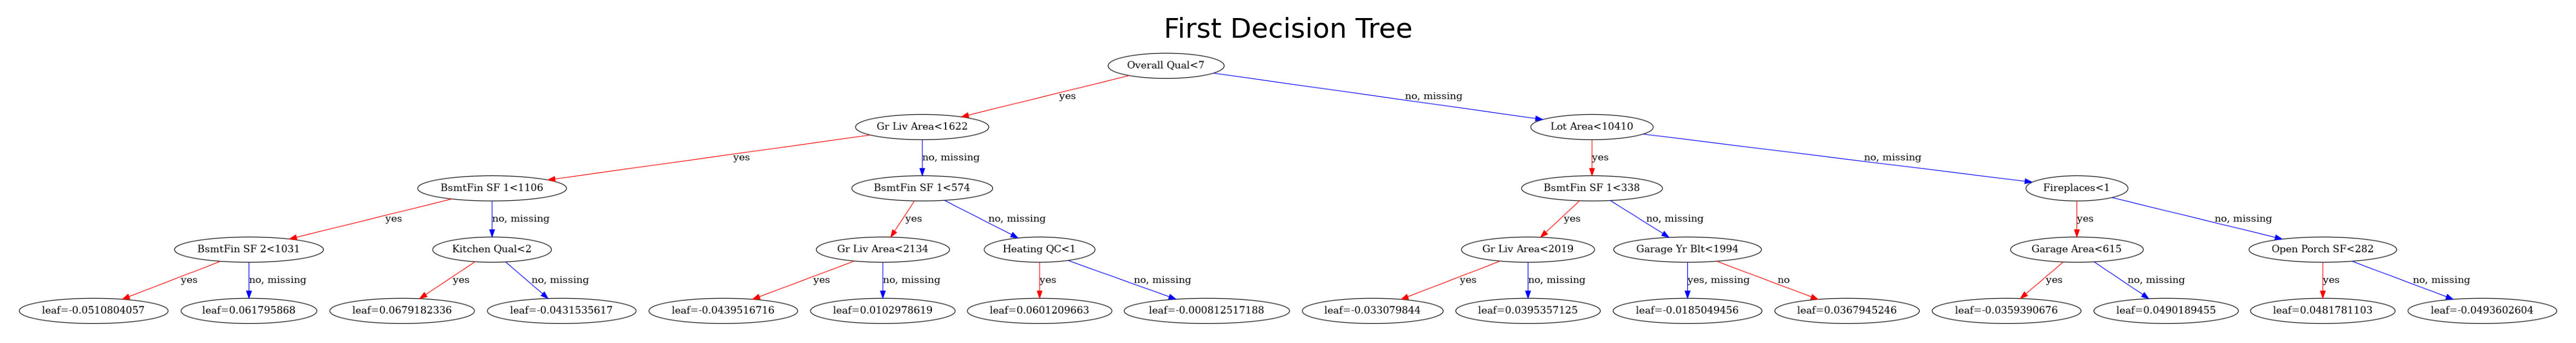

In [29]:
from xgboost import plot_tree

num_trees = model.best_iteration if hasattr(model, 'best_iteration') else model.get_booster().num_boosted_rounds() - 1
fig = plt.figure(figsize=(20, 40), dpi=300, constrained_layout=False) 
axis = fig.add_subplot(111)
plot_tree(model, tree_idx=num_trees, ax=axis)
plt.title("First Decision Tree")
plt.show()

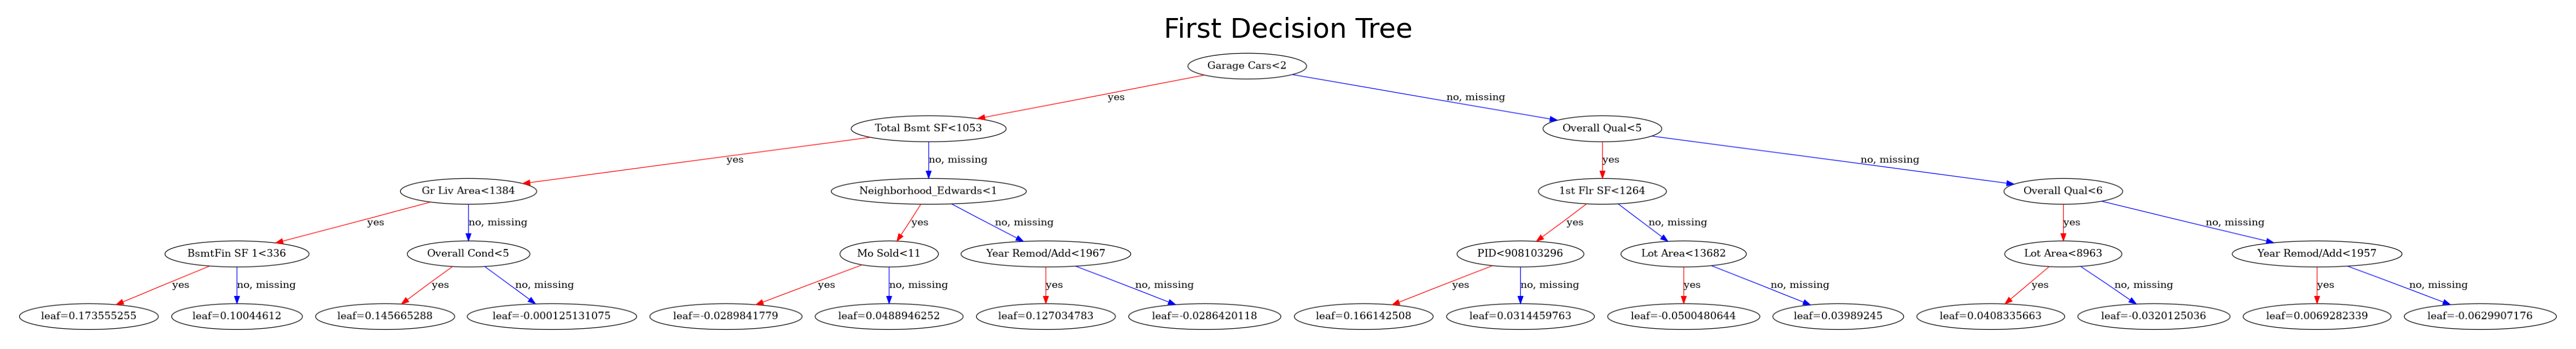

In [28]:
from xgboost import plot_tree

fig = plt.figure(figsize=(20, 40), dpi=300, constrained_layout=False) 
axis = fig.add_subplot(111)
plot_tree(model, tree_idx=0, ax=axis)
plt.title("First Decision Tree")
plt.show()



<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

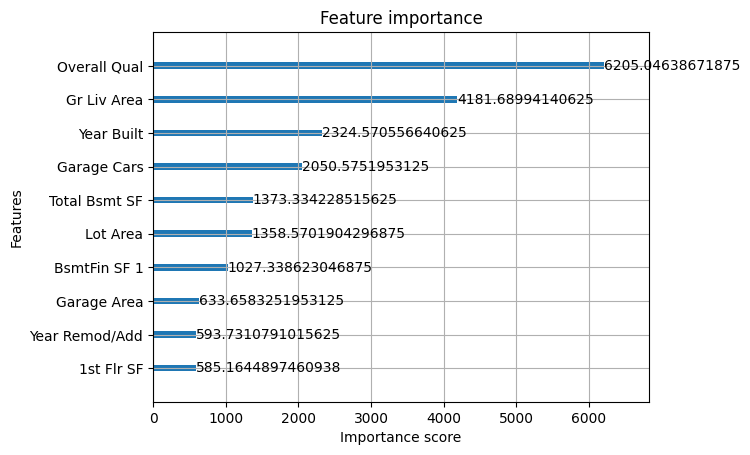

In [ ]:
# feature importance 
fig, axis = plt.subplots(2, 1)
axis[0] = xgb.plot_importance(model, max_num_features=10, importance_type='total_gain')
axis[1] = xgb.plot_importance(model2, max_num_features=10, importance_type='total_gain')

In [36]:
# metrics 
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score

print(f"Accuracy: {accuracy_score(Y_test, y_pred)}")
print(f"F1 Score: {f1_score(Y_test, y_pred, average=None)}")
print(f"Recall Score: {recall_score(Y_test, y_pred, average=None)}")
print(f"Precision Score: {precision_score(Y_test, y_pred, average=None)}")

Accuracy: 0.8054607508532423
F1 Score: [0.84459459 0.72916667 0.76450512 0.88135593]
Recall Score: [0.84459459 0.72413793 0.76190476 0.89041096]
Precision Score: [0.84459459 0.73426573 0.76712329 0.87248322]


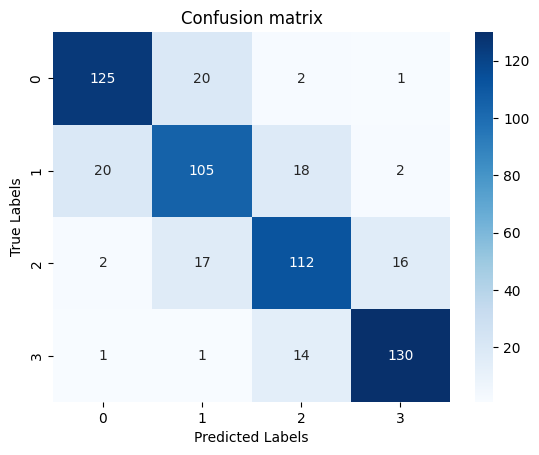

In [37]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(Y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion matrix')
plt.show()


In [38]:
# k fold-validation 
from sklearn.model_selection import KFold, cross_val_score

ks = [5, 10]

for k in ks:
    kf = KFold(n_splits=k, shuffle=True, random_state=12)
    scores = cross_val_score(model, X, Y, cv=kf, scoring='accuracy')
    print(f"Scores from {k}Validation: {scores}")
    print(f"The overall score: {np.mean(scores):.2f}")


Scores from 5Validation: [0.778157   0.79692833 0.79180887 0.79145299 0.77264957]
The overall score: 0.79
Scores from 10Validation: [0.77474403 0.77133106 0.76109215 0.80887372 0.80887372 0.80546075
 0.77474403 0.778157   0.79109589 0.76712329]
The overall score: 0.78


In [67]:
# lightgbm trainning
import lightgbm as lgbm
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score


X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

params = {
    "objective": "multiclass",
    "num_class": 4,
    "learning_rate": 0.1,
    "metric": "multi_logloss"
}

num_round = 100
# print(len(set(Y)))

train_data = lgbm.Dataset(X_train, label=Y_train)
test_data = lgbm.Dataset(X_test, label=Y_test, reference=train_data)

light_model = lgbm.train(params, train_data, num_round, valid_sets=[test_data])

y_pred = light_model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
print('\n\n')
print(f"Accuracy: {accuracy_score(Y_test, y_pred)}")
print(f"F1 Score: {f1_score(Y_test, y_pred, average=None)}")
print(f"Recall Score: {recall_score(Y_test, y_pred, average=None)}")
print(f"Precision Score: {precision_score(Y_test, y_pred, average=None)}")



[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001437 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4359
[LightGBM] [Info] Number of data points in the train set: 2342, number of used features: 161
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -1.383736
[LightGBM] [Info] Start training from score -1.399187
[LightGBM] [Info] Start training from score -1.373566
[LightGBM] [Info] Start training from score -1.388860



Accuracy: 0.7952218430034129
F1 Score: [0.83276451 0.70819672 0.74285714 0.89795918]
Recall Score: [0.80794702 0.72483221 0.74820144 0.89795918]
Precision Score: [0.85915493 0.69230769 0.73758865 0.89795918]
